In [1]:
! pip install ohmeow-blurr -Uqq
! pip install transformers[sentencepiece] -Uqq
! pip install datasets -Uqq
! pip install bert_score -Uqq

In [41]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
import pdb
import os
import nltk
nltk.download('punkt')

from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, PreTrainedTokenizerBase, logging
from fastai.text.all import *
from blurr.utils import print_versions
from blurr.text.utils import BlurrText, get_hf_objects
from blurr.text.data.seq2seq.core import Seq2SeqBatchTokenizeTransform, Seq2SeqPreprocessor, Seq2SeqTextBlock, default_text_gen_kwargs
from blurr.text.modeling.core import BaseModelCallback, BaseModelWrapper, Blearner
from blurr.text.modeling.seq2seq.core import Seq2SeqMetricsCallback, blurr_seq2seq_splitter

[nltk_data] Downloading package punkt to /home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
NLP = BlurrText()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.11.0a0+17540c5
fastai: 2.5.6
transformers: 4.18.0


In [44]:
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: Quadro RTX 5000


In [45]:
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: Quadro RTX 5000


In [46]:
raw_datasets = load_dataset("cnn_dailymail", "3.0.0", split=["train", "validation"])
raw_datasets

W0420 17:57:08.813176 140245862426432 builder.py:542] Reusing dataset cnn_dailymail (/home/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/2 [00:00<?, ?it/s]

[Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 287113
 }),
 Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 13368
 })]

In [47]:
print(raw_datasets[0][0].keys())
print(raw_datasets[0][0]["highlights"])

print(raw_datasets[1][0].keys())
print(raw_datasets[1][0]["highlights"])

dict_keys(['article', 'highlights', 'id'])
Syrian official: Obama climbed to the top of the tree, "doesn't know how to get down"
Obama sends a letter to the heads of the House and Senate .
Obama to seek congressional approval on military action against Syria .
Aim is to determine whether CW were used, not by whom, says U.N. spokesman .
dict_keys(['article', 'highlights', 'id'])
Accident happens in Santa Ynez, California, near where Crosby lives .
The jogger suffered multiple fractures; his injuries are not believed to be life-threatening .


In [48]:
raw_train_ds = raw_datasets[0].shuffle(seed=42).select(range(1000))
raw_valid_ds = raw_datasets[1].shuffle(seed=42).select(range(200))

len(raw_train_ds) + len(raw_valid_ds)

W0420 17:57:11.920651 140245862426432 arrow_dataset.py:2785] Loading cached shuffled indices for dataset at /home/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234/cache-516bef66c83f0d37.arrow
W0420 17:57:11.931447 140245862426432 arrow_dataset.py:2785] Loading cached shuffled indices for dataset at /home/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234/cache-e7e93c0052828394.arrow


1200

In [49]:
raw_train_df = pd.DataFrame(raw_train_ds)
raw_valid_df = pd.DataFrame(raw_valid_ds)

raw_train_df.head(2)

,article,highlights,id
0,"A protester in Ferguson was arrested during a demonstration on Thursday night - and live-tweeted her entire experience. Brittany Ferrell, a nursing student at the University of Missouri-Saint Louis, was one of 13 people detained by officers in the conflicted Missouri city for 'noise disruption'. The detention has sparked an investigation by the American Civil Liberties Union as lawyers accuse officers of overstretching their powers. Scroll down for video . Arrested: This is Brittany Ferrell, the nursing student and protester who live-tweeted her arrest in Ferguson . Tweeting in handcuffs, ...","Brittany Ferrell, nursing student, was arrested with 12 people on Thursday .\nThey were calling on police take responsibility for Michael Brown's death .\nMs Ferrell tweeted as she was arrested, piled in a small wagon with 7 others .\nThey were accused of 'noise disruption', put in orange jumpsuits and cuffed .\nOfficers now being investigated, lawyers claim they 'overstretched powers'",1e01f238418c31d4e9093f6334e0232babeb639a
1,"A day after confirming it had lost the ability to display Instagram images, Twitter has rolled out its own library of retro filters for its Android and iPhone apps. The eight filters are the usual suspects we've come to expect from mobile photo apps, including desaturated, black and white and high contrast. There are auto-adjust and cropping options, as well as a helpful grid view that lets you see what each filter will look like at once. ""The latest versions of Twitter for iPhone and Twitter for Android introduce a few new ways to enhance the images you tweet,"" said Twitter senior designe...",Twitter has added photo filters to its Android and iOS mobile apps .\nThe addition will help Twitter compete against Facebook-owned Instagram .\nThis is the first time the social network has offered image editing tools .,6f89645bff243fe9ce2a0509e5ca01912abf0d10


In [50]:
pretrained_model_name = "facebook/bart-large-cnn"
model_cls = AutoModelForSeq2SeqLM

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=model_cls)

loading configuration file https://huggingface.co/facebook/bart-large-cnn/resolve/main/config.json from cache at /home/.cache/huggingface/transformers/199ab6c0f28e763098fd3ea09fd68a0928bb297d0f76b9f3375e8a1d652748f9.930264180d256e6fe8e4ba6a728dd80e969493c23d4caa0a6f943614c52d34ab
Model config BartConfig {
  "_name_or_path": "facebook/bart-large-cnn",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "force_bos_token_to_be_gen

In [51]:
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [52]:
text_gen_kwargs = {}
if hf_arch in ["bart", "t5"]:
    text_gen_kwargs = {**hf_config.task_specific_params["summarization"], **{"max_length": 30, "min_length": 10}}

# not all "summarization" parameters are for the model.generate method ... remove them here
generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
for k in text_gen_kwargs.copy():
    if k not in generate_func_args:
        del text_gen_kwargs[k]

if hf_arch == "mbart":
    text_gen_kwargs["decoder_start_token_id"] = hf_tokenizer.get_vocab()["en_XX"]

In [53]:
tok_kwargs = {}
if hf_arch == "mbart":
    tok_kwargs["src_lang"], tok_kwargs["tgt_lang"] = "en_XX", "en_XX"

In [54]:
batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch,
    hf_config,
    hf_tokenizer,
    hf_model,
    max_length=256,
    max_target_length=130,
    tok_kwargs=tok_kwargs,
    text_gen_kwargs=text_gen_kwargs,
)

blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader("article"), get_y=ColReader("highlights"), splitter=RandomSplitter())

In [55]:
dls = dblock.dataloaders(raw_train_df, bs=4)

In [56]:
b = dls.one_batch()
len(b), b[0]["input_ids"].shape, b[1].shape

(2, torch.Size([4, 256]), torch.Size([4, 130]))

In [57]:
dls.show_batch(dataloaders=dls)

,text,target
0,"<s> By. Daily Mail Reporter. PUBLISHED:. 08:16 EST, 14 May 2012. |. UPDATED:. 22:07 EST, 14 May 2012. Barack Obama's latest campaign gambit follows a familiar line of attack as it uses Mitt Romney's private equity past to cast the Republican candidate as greedy, job-killing corporate titan with little concern for the working class. The President is not the first of Mr Romney's opponents to try and paint the former governor of Massachusetts as a heartless uber-capitalist - even his Republican rivals used the same tactic during the heated primary battle. But Mr Obama's campaign seems to have been particularly unoriginal - as his attack ad is almost identical to one produced by Ted Kennedy for his Senate campaign against Mr Romney in 1994, featuring unemployed workers complaining about Bain Capital, the firm founded by Mr Romney. The timing of the Obama assault on private equity is also unfortunate, as on Monday night the President attended a fundraiser hosted by Democratic supporter Hamilton E. James, chief operating officer of the Blackstone Group, which is believed to be the world's largest private equity firm. SCROLL DOWN FOR THE VIDEO. Lost jobs: Joe Soptic (left) and Jack Cobb (right) are both featured in</s>",President follows familiar line of attack as he highlights private equity past.\nAd released on the same day Obama attended fundraiser hosted by top private equity boss in New York.
1,"<s> (CNN) -- Voters in North Carolina, Indiana and Ohio on Tuesday kick off five straight weeks of primary contests that could give us a clearer indication of whether establishment Republicans have the upper hand against the tea party movement for control of the party. The results could back up recent tough talk from Senate GOP leader Mitch McConnell, who predicted big wins for incumbents facing primary challenges from the right, saying, ""I think we are going to crush them everywhere."" And they may have a major impact in determining whether Republicans retake the majority in the Senate. Since the birth of the tea party movement in 2009, primary challenges from the right have produced major headlines and headaches for the GOP and hurt the party's chances of winning back the Senate from Democrats in the past two election cycles. Candidates backed by the tea party movement and other grass-roots conservatives effectively cost the GOP five winnable Senate elections the last two cycles in Nevada, Delaware, Colorado, Indiana and Missouri. Complete coverage: 2014 midterm elections. Two months ago, McConnell, whom the right sees as part of the problem in Washington, told The New York Times that when it came to tea party challenges, ""I don't think they are going to have a single nominee anywhere in the country."" His prediction might come true</s>","Establishment Republicans are fighting back more strongly against challenges from the right.\nWith a number of vulnerable Democrats in the Senate, GOP thinks it can win control.\nNorth Carolina primary seen as a key test of establishment-vs.-tea party scenario."
2,"<s> Boxing legend Floyd 'Money' Mayweather Jnr is used to winning, in fact, he's never been beaten inside the ring. However, his biggest fight is happening outside of the hempen square, with calls for him to be banned from entering Australia next week because of his abusive past. An on-line petition has been launched via change.org to stop him from visiting the country because it states 'he abused his ex-partner in front of his children and went to jail after abusing five different women'. Mayweather, 37, was jailed in 2012 for an attack (two years earlier) on his ex-girlfriend and needs the Immigration Minister Peter Dutton to rubber stamp his visa application before heading down under next week, where he's expected to be the star turn at two dinners in Melbourne and Sydney. His local promoter, Max Markson, remains confident the boxing millionaire will be allowed to fly in with his entourage of 30 people. Boxer Floyd May

In [58]:
seq2seq_metrics = {
    "rouge": {
        "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
        "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
    },
    "bertscore": {"compute_kwargs": {"lang": "en"}, "returns": ["precision", "recall", "f1"]},
}

In [59]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

# learn = learn.to_native_fp16() #.to_fp16()
learn.freeze()

In [60]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 130 x 1024      
Embedding                                 51470336   False     
Embedding                                 51470336   False     
____________________________________________________________________________
                     4 x 1024            
BartLearnedPositionalEmbedding                      1050624    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
LayerNorm                                 2048       True      
GELUActivation                                                 
____________________________________________________________________________
                     4 x 256 x 4096      
Linear                        

In [61]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds), preds["loss"].shape, preds["logits"].shape

(3, torch.Size([]), torch.Size([4, 130, 50264]))

SuggestedLRs(minimum=5.754399462603033e-05, steep=1.9054607491852948e-06, valley=5.248074739938602e-05, slide=2.2908675418875646e-06)

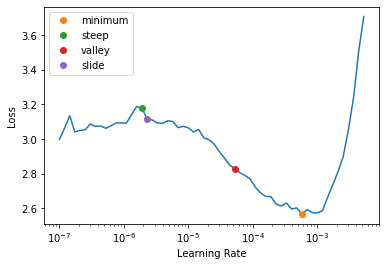

In [62]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [64]:
learn.fit_one_cycle(4, lr_max=5e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.374692,1.754047,0.302789,0.144572,0.235210,0.283178,0.898134,0.863143,0.880076,01:48
1,1.047386,1.857749,0.318298,0.152608,0.247784,0.297073,0.900616,0.864910,0.882221,01:32
2,0.575400,2.177894,0.315706,0.151686,0.244480,0.293978,0.902227,0.865997,0.883544,01:33
3,0.309700,2.383531,0.311670,0.146428,0.244857,0.292520,0.900462,0.865653,0.882529,01:33


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-large/resolve/main/config.json from cache at /home/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_c

In [65]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"Emails from reporter Liz MacKean to friend expressing concerns about management. interference 'blocked by Panorama from appearing in show' By. Emily Allen. PUBLISHED:. 02:41 EST, 23 October 2012. |. UPDATED:. 03:08 EST, 23 October 2012. Calls: Harriet Harman, Labour's shadow culture. secretary, called for an independent inquiry. into the BBC's handling of the allegations. BBC boss George Entwistle will be quizzed about the handling of the Jimmy Savile sex abuse scandal by MPs today as calls wer","Harriet Harman, Labour's shadow culture.\nsecretary, calls for an independent inquiry.\ninto the BBC's handling of the abuse claims.\nFollows last night's Panorama which highlighted different explanations given by BBC.\nbosses about why the Newsnight do","[ Harriet Harman, Labour's shadow culture .\nsecretary, calls for an independent inquiry .\ninto the BBC's handling, Casey Anthony was acquitted in June 2013 of murdering her daughter Caylee .\nCheney Mason, her defense attorney, says that, Obama says the Affordable Care Act ""stopped $716 billion from Medicare""\nRyan calls that claim ""simply not, Alexis Wright, 29, charged with engaging a prostitute after police raided her home in Kennebunk, New Hampshire .\n]"


In [66]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French lRicense plates. CNN's Andreena Narayan 
contributed to this report.
"""

outputs = learn.blurr_generate(test_article, key="summary_texts", num_return_sequences=3)
outputs

[{'summary_texts': [" Robbers stole hundreds of thousands of Swiss francs from a Swiss casino .\nThere were no serious injuries, although one guest was kicked in the head by one of the robbers .\nThe robbers spoke French and drove vehicles with French lRicense plates .\nA woman driving by unknowingly blocked the robbers' vehicles and was beaten by a gunman, police say .",
   " Robbers stole hundreds of thousands of Swiss francs from a Swiss casino .\nThere were no serious injuries, although one guest was kicked in the head by one of the robbers .\nThe robbers spoke French and drove vehicles with French lRicense plates .\nA woman driving by unknowingly blocked the robbers' vehicles and was beaten by a gunman .",
   " Robbers stole hundreds of thousands of Swiss francs from a Swiss casino .\nThere were no serious injuries, although one guest was kicked in the head by one of the robbers .\nThe robbers spoke French and drove vehicles with French lRicense plates .\nA woman driving by and un

In [67]:
cricket_over_12="""
Nehra to Mandeep, FOUR, first boundary for Mandeep and RCB. Full and on the pads, needed to be put away and Mandeep did just that, picked it up and dispatched it over mid-wicket, couple of bounces and into the fence",Nehra to Mandeep,FOUR.
Nehra to Mandeep, FOUR, back-to-back boundaries to end the first over. Again, Nehra is a tad short in his length, Mandeep had the width to cut and he didn't try to hit it hard, just placed it behind point and Bhuvi at third man gave up the chase pretty quickly",Nehra to Mandeep,FOUR.
Henriques to Kedar Jadhav, FOUR, hit straight back at Henriques and he was late to get his hand up. Once more the off-cutter which almost fooled Jadhav, who shimmied down and checked his drive, middled it alright to beat the mid-off fielder",Henriques to Kedar Jadhav,FOUR.
Nehra to Kedar Jadhav, FOUR, another full toss, it's Jadhav this time and he picks his spot into the deep mid-wicket fence. Not great bowling from Nehra. He's missing the yorker by quite a bit",Nehra to Kedar Jadhav,FOUR.
Nehra to Kedar Jadhav, FOUR, four more. Jadhav starting to really find his timing now and he's looking dangerous. This is smart batting rather than just throwing his bat at everything. He knows that fine leg is up and so he waits for the back of a length delivery to come to him before pulling it over the fielder. Nehra under pressure",Nehra to Kedar Jadhav,FOUR
Henriques to Kedar Jadhav, out Kedar Jadhav Run Out!! 1 run completed. Cutting has conjured a wicket out of nowhere. That's a sensational throw from the deep. My goodness. He's absolutely nailed the stump from long leg and Jadhav is out of here. This is a huge moment in the context of the match, especially as Jadhav was looking so good. Even this shot which he played was extraordinary. It was a length ball outside off, Jadhav sat on his back knee and scooped it over short fine leg. He was a little slow to decide on the second run, maybe a little hesitant and boy did Cutting make him pay! More than a couple of feet short, even with a dive. Kedar Jadhav run out (Cutting) 31(16) [4s-4 6s-1]",Henriques to Kedar Jadhav,OUT.
"""

outputs = learn.blurr_generate(cricket_over_12, key="summary_texts", num_return_sequences=3)
outputs

[{'summary_texts': [" Kedar Jadhav scores 31 runs off 31 balls with four fours and a six .\nAdil Shastri takes over at the end of the over and starts RCB's innings with a four .\nMandeep and Bhuvi score 38 runs for the first wicket before India lose by eight wickets .\nSunil Narvee takes charge of the bowling with an impressive display for India A .",
   " Kedar Jadhav scores 31 runs off 31 balls with four fours and a six .\nAdil Shastri takes over at the end of the over and starts RCB's innings with a four .\nMandeep and Bhuvi score 38 runs for the first wicket before India lose by eight wickets .\nSunil Narvee takes charge of the bowling with an impressive display .",
   " Kedar Jadhav scores 31 runs off 31 balls with four fours and a six .\nAdil Shastri takes over at the end of the over and starts RCB's innings with a four .\nMandeep and Bhuvi score 38 runs for the first wicket before India lose by eight wickets ."]}]

In [68]:
learn.export(fname="model.pkl")

TypeError: cannot pickle '_thread.lock' object